In [28]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import sys
sys.path.append("..")

from LeastSquare import LeastSquare as LS
from LinearRegression import LinearRegression as LR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2"))
sns.set_context('notebook', font_scale=1.25, rc={"lines.linewidth": 3})

# function Sin

In [29]:
sin = lambda x: np.sin(np.pi*x)

n_res = 1000
x = np.linspace(-1, 1, n_res)
y = sin(x)
noise = np.random.randn(n_res)/5
y_noise = y + noise

## Random Sample ranint = Discrete Uniform

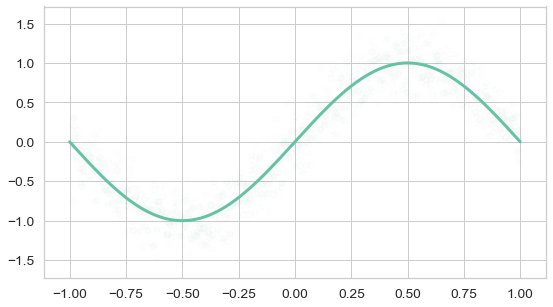

In [30]:
fig = plt.figure(figsize=(9, 5))
plt.plot(x, y)
plt.scatter(x, y_noise, alpha=0.01)
plt.savefig('./01-scatter.png', dpi=150)

# fold array and roll array for cross validation

In [31]:
def fold_arr(arr, num_fold=10):
    """
        fold numpy arr as num_fold
        for cross validation
    """
    fold_list = []
    fold_size = int(len(arr)/num_fold)
    for i in range(num_fold):
        if i == num_fold - 1:
            s  = arr[i*fold_size:]
        else:
            s  = arr[i*fold_size:(i+1)*fold_size]
        fold_list.append(s)
    return np.array(fold_list)

def roll_fold(arr):
    rolled = np.roll(arr, 1, axis=0)
    return rolled


# MSE

In [32]:
def mse(x, y):
    mse = np.mean((x-y)**2)
    return mse

In [33]:
def create_degree_x(raw_x, degree):
    new_x = []
    for w in raw_x:
        xx = []
        for i in range(degree+1):
            xx.append(w**i)
        new_x.append(xx)
    return np.array(new_x)

In [38]:
def train_folds(x_fold, y_fold, degree):
    
    fold_w = []
    fold_test_err = []
    fold_train_err = []
    
    for i in range(len(x_fold)):
        x_train = x_fold[:-1].flatten()
        y_train = y_fold[:-1].flatten()
        x_test = x_fold[-1].flatten()
        y_test = x_fold[-1].flatten()
        
        x_train_poly = create_degree_x(x_train, degree)
        x_test_poly = create_degree_x(x_test, degree)
        
#         polynomial_features= PolynomialFeatures(degree=degree)
#         x_train_poly = polynomial_features.fit_transform(x_train[:, np.newaxis])
#         x_test_poly = polynomial_features.fit_transform(x_test[:, np.newaxis])
#         model = LinearRegression()
#         model.fit(x_train_poly, y_train[:, np.newaxis])
#         w = model.coef_[0]

        
        ls = LS(x_train_poly, y_train)
        w = ls.parameters
        fold_w.append(w)

        
        train_err = mse(x_train_poly.dot(w.T), y_train)
        test_err = mse(x_test_poly.dot(w.T), y_test)
        fold_train_err.append(train_err)
        fold_test_err.append(test_err)
        
        x_fold = roll_fold(x_fold)
        y_fold = roll_fold(y_fold)
    
    fold_w = np.round(np.array(fold_w), 4)
    fold_test_err = np.round(np.array(fold_test_err), 4)
    fold_train_err = np.round(np.array(fold_train_err), 4)
    return fold_w, fold_test_err, fold_train_err

# funtion สำหรับ train/test fold วนจนกว่าจะครบทุก fold

ROUND: 0
ROUND: 1
ROUND: 2
ROUND: 3
ROUND: 4
ROUND: 5
ROUND: 6
ROUND: 7
ROUND: 8
ROUND: 9


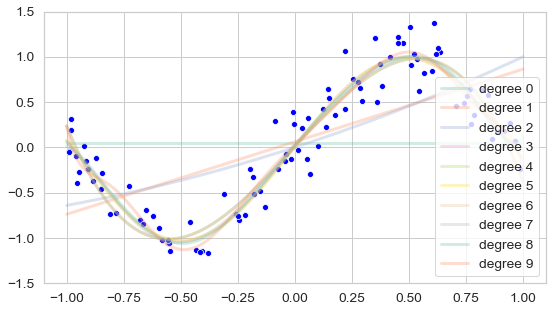

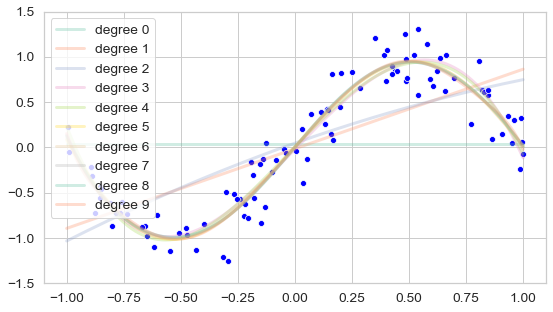

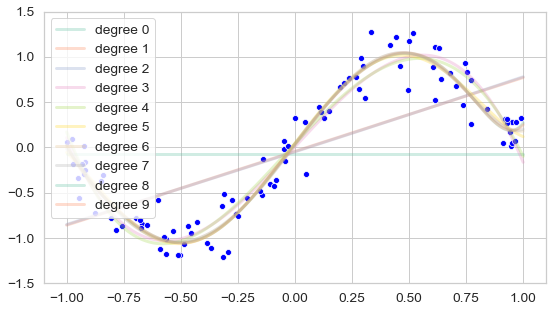

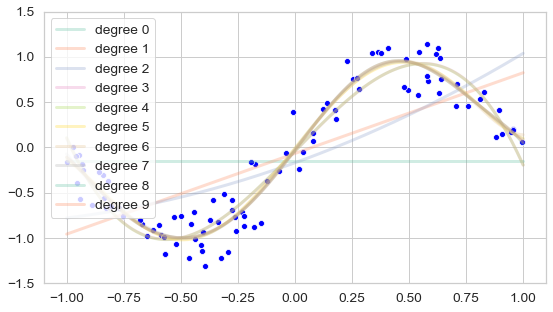

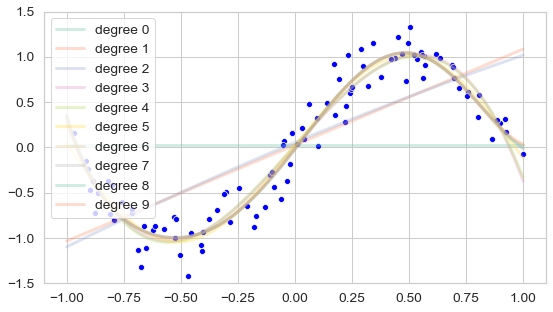

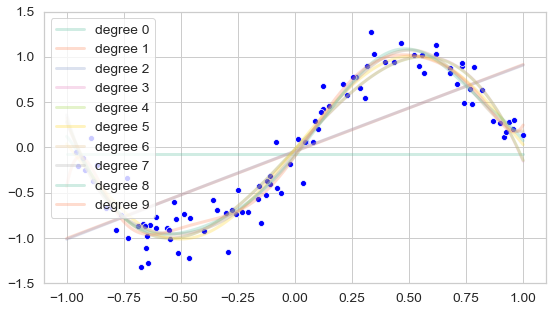

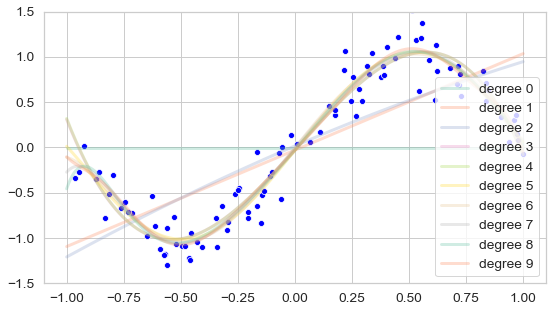

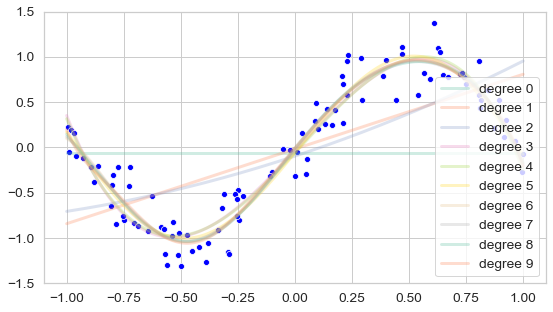

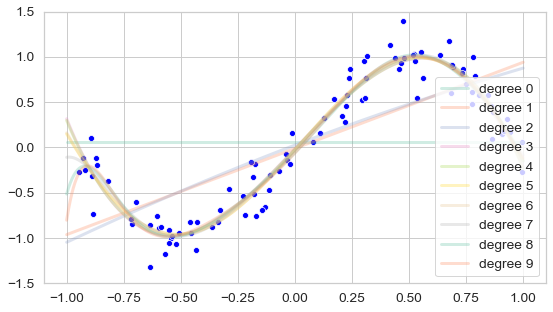

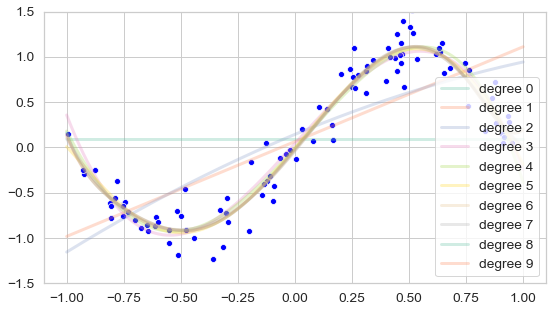

In [39]:
degree_list = list(range(0, 10))
repeat = 10
num_fold = 10
sample_size = 100
repeat_test_errors = []
repeat_train_errors = []
repeat_out_errors = []
repeat_w = []

for r in range(repeat):
    # list ของ test/train error ตาม แต่ละ degree, มี 10 fold error
    # error of degree i = [fold-1-e, fold-2-e, ... fold-n-e]
    test_errors = []
    train_errors = []
    # out of sample error จาก model เฉลี่ย
    out_errors = []
    
    weights = []
    
    # select unique index/ for unique sample
    sample_ind = np.random.randint(0, n_res, sample_size)
    ind_unique = np.unique(sample_ind).shape[0] == sample_size
    while not(ind_unique):
        sample_ind = np.random.randint(0, n_res, sample_size)
        ind_unique = np.unique(sample_ind).shape[0] == sample_size
    
    x_sample = np.take(x, sample_ind)
    y_sample = np.take(y_noise, sample_ind)

    x_fold = fold_arr(x_sample, num_fold)
    y_fold = fold_arr(y_sample, num_fold)

    print(f'ROUND: {r}')
    
    fig = plt.figure(figsize=(9, 5))
    plt.axis([-1.1, 1.1, -1.5, 1.5])
    sns.scatterplot(x_sample, y_sample, color='blue')
    for degree in degree_list:
        w, test_err, train_err = train_folds(x_fold, y_fold, degree)
        avg_w = np.mean(w, axis=0)
        x_aug = create_degree_x(x, degree)
        y_model = x_aug.dot(avg_w.T)
        out_err = mse(y_model, y_noise)

        test_errors.append(test_err)
        train_errors.append(train_err)
        out_errors.append(out_err)
        sns.lineplot(x, y_model, label=f'degree {degree}', alpha=0.3)
        weights.append(avg_w)
        
    repeat_test_errors.append(test_errors)   
    repeat_train_errors.append(train_errors)
    repeat_out_errors.append(out_errors)
    repeat_w.append(weights)
    

In [40]:
repeat_out_errors = np.array(repeat_out_errors)
repeat_test_errors = np.array(repeat_test_errors)
repeat_train_errors = np.array(repeat_train_errors)

print(repeat_test_errors.shape)
print(repeat_train_errors.shape)

(10, 10, 10)
(10, 10, 10)


# Out of Sample Error

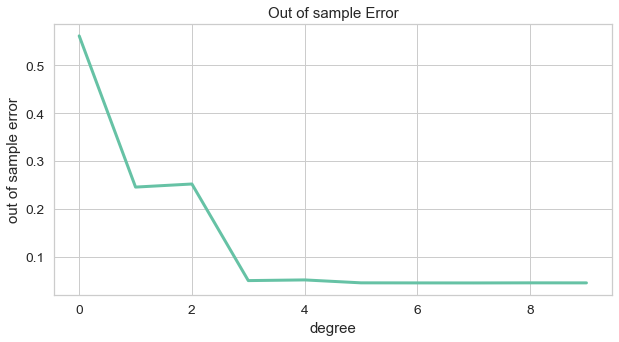

In [41]:
fig = plt.figure(figsize=(10, 5))
sns.lineplot(degree_list, out_errors)
plt.title('Out of sample Error')
plt.xlabel('degree')
plt.ylabel('out of sample error')

if np.amax(out_errors) > 200:
    axes = plt.gca()
    axes.set_ylim([-10, 200])
    
plt.savefig('./01-out-of-sample-error.png', dpi=150)

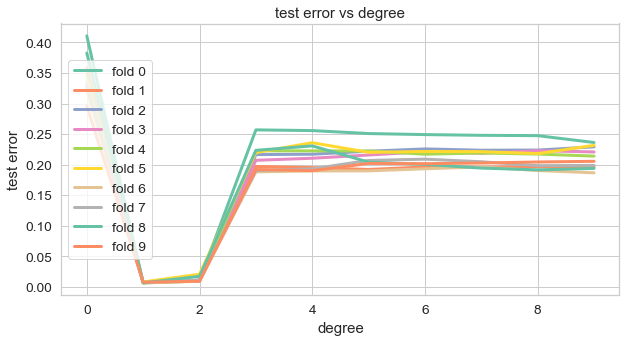

In [42]:
fig = plt.figure(figsize=(10, 5))
mean_test_errors = np.mean(repeat_test_errors, axis=0).T
num_fold = len(mean_test_errors)

for i in range(num_fold):
    sns.lineplot(degree_list, mean_test_errors[i], label=f'fold {i}')
    
if np.amax(mean_test_errors) > 20:
    axes = plt.gca()
    axes.set_ylim([-1, 20])
    
plt.xlabel('degree')
plt.ylabel('test error')
plt.title('test error vs degree')
plt.savefig('./01-test-error.png', dpi=150)

[[0.53009 0.24161 0.23774 0.04258 0.04222 0.03822 0.03761 0.03733 0.03713
  0.03656]
 [0.52617 0.24487 0.24169 0.04242 0.04193 0.03747 0.03686 0.03657 0.03629
  0.03573]
 [0.53879 0.24328 0.24138 0.04194 0.04157 0.03752 0.03674 0.03646 0.0363
  0.03554]
 [0.53392 0.24302 0.24069 0.04089 0.04037 0.0366  0.0358  0.03558 0.03528
  0.0347 ]
 [0.52942 0.24025 0.23821 0.04022 0.03967 0.03591 0.03538 0.03514 0.03484
  0.03424]
 [0.53518 0.23989 0.23545 0.04007 0.03962 0.03635 0.03577 0.03558 0.0353
  0.03464]
 [0.53005 0.23858 0.23524 0.04123 0.04088 0.03696 0.03638 0.03616 0.03582
  0.0352 ]
 [0.52917 0.24197 0.23805 0.04214 0.04165 0.03797 0.03724 0.03695 0.0366
  0.03593]
 [0.53461 0.24185 0.23647 0.04035 0.03982 0.0359  0.03529 0.03495 0.03467
  0.03412]
 [0.5307  0.24257 0.24051 0.04176 0.0413  0.0376  0.03709 0.03687 0.03658
  0.03597]]


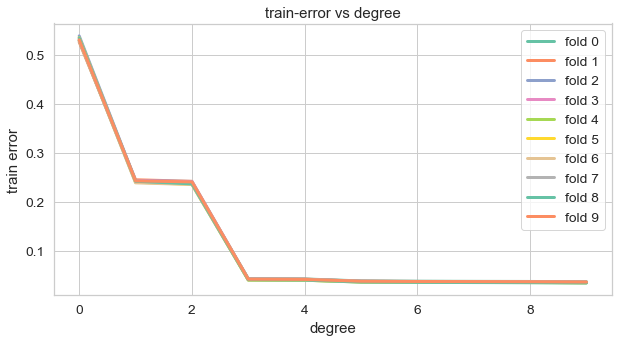

In [43]:
fig = plt.figure(figsize=(10, 5))
mean_train_errors = np.mean(repeat_train_errors, axis=0).T
print(mean_train_errors)
num_fold = len(mean_train_errors)

for i in range(num_fold):
    sns.lineplot(degree_list, mean_train_errors[i], label=f'fold {i}')

if np.amax(mean_train_errors) > 20:
    axes = plt.gca()
    axes.set_ylim([-1, 20])
    
plt.xlabel('degree')
plt.ylabel('train error')
plt.title('train-error vs degree')
plt.savefig('./01-train-error.png', dpi=150)

# Calculate Bias Variance

In [44]:
repeat_w = np.array(repeat_w)
mean_repeat_w = np.mean(repeat_w, axis=0)

In [45]:
bias = []

for d in range(len(degree_list)):
        x_aug = create_degree_x(x, d)
        y_predict = x_aug.dot(mean_repeat_w[d].T)
        b = mse(y_predict, y_noise)
        bias.append(b)
        

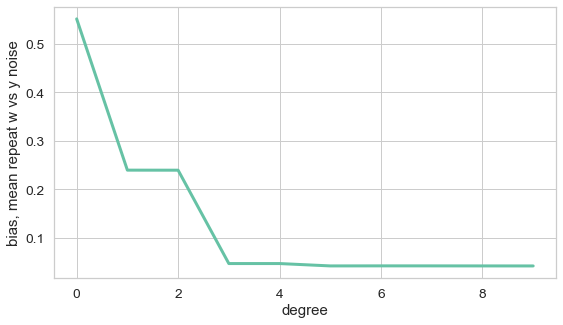

In [46]:
fig = plt.figure(figsize=(9, 5))

sns.lineplot(degree_list, bias)
if np.amax(bias) > 100:
    axes = plt.gca()
    axes.set_ylim([-5, 100])

plt.xlabel('degree')
plt.ylabel('bias, mean repeat w vs y noise')
plt.savefig('./01-bias.png', dpi=150)

In [47]:
variance = []
for d in range(len(degree_list)):
    x_aug = create_degree_x(x, d)
    all_model_res = [[w.dot(x_aug.T)] for w in repeat_w[:, d]]
    var = mse(np.array(all_model_res), x_aug.dot(mean_repeat_w[d].T))
    variance.append(var)

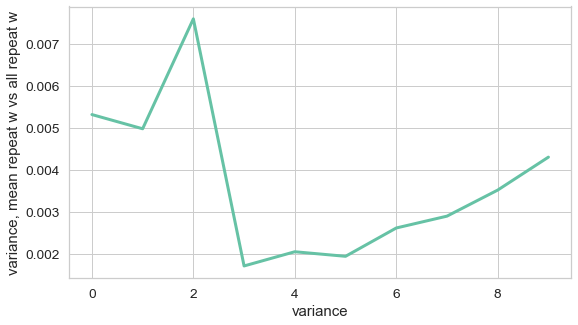

In [48]:
fig = plt.figure(figsize=(9, 5))
sns.lineplot(degree_list, variance)
if np.amax(variance) > 100:
    axes = plt.gca()
    axes.set_ylim([-5, 100])
plt.xlabel('variance')
plt.ylabel('variance, mean repeat w vs all repeat w')
plt.savefig('./01-variance.png', dpi=150)